   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

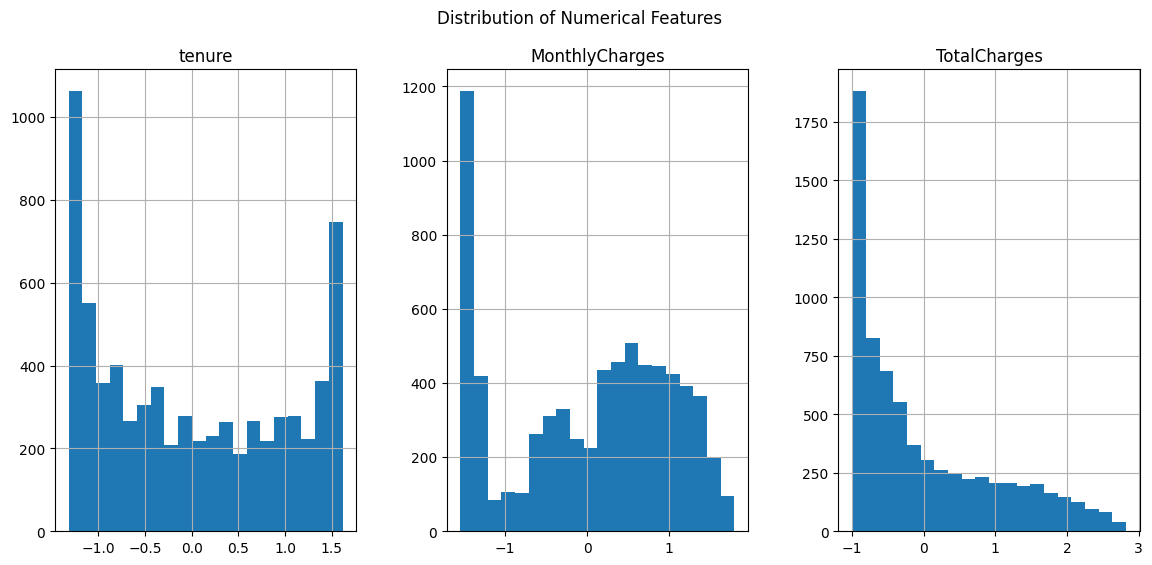

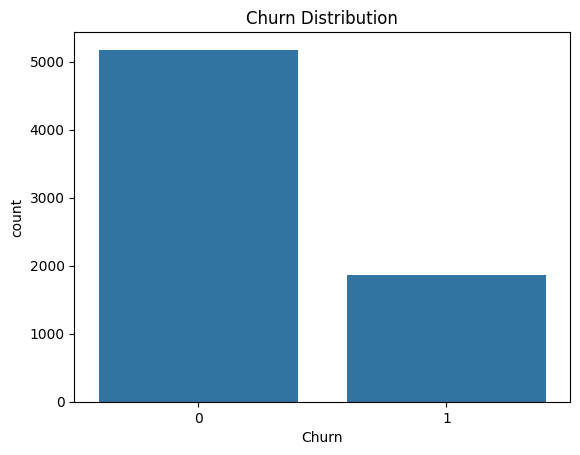

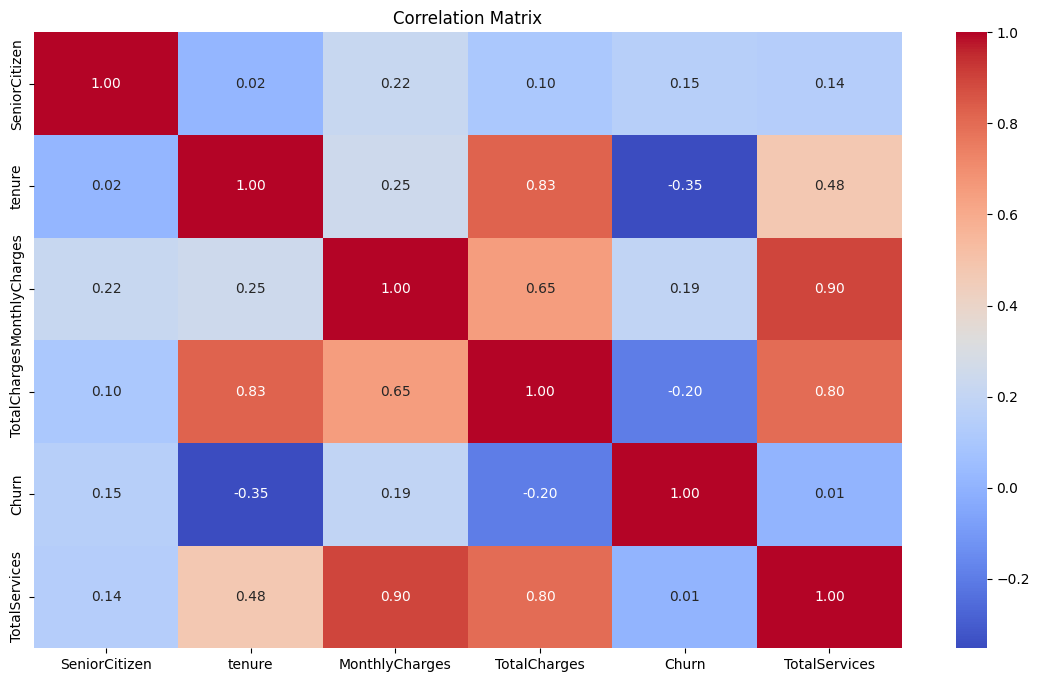

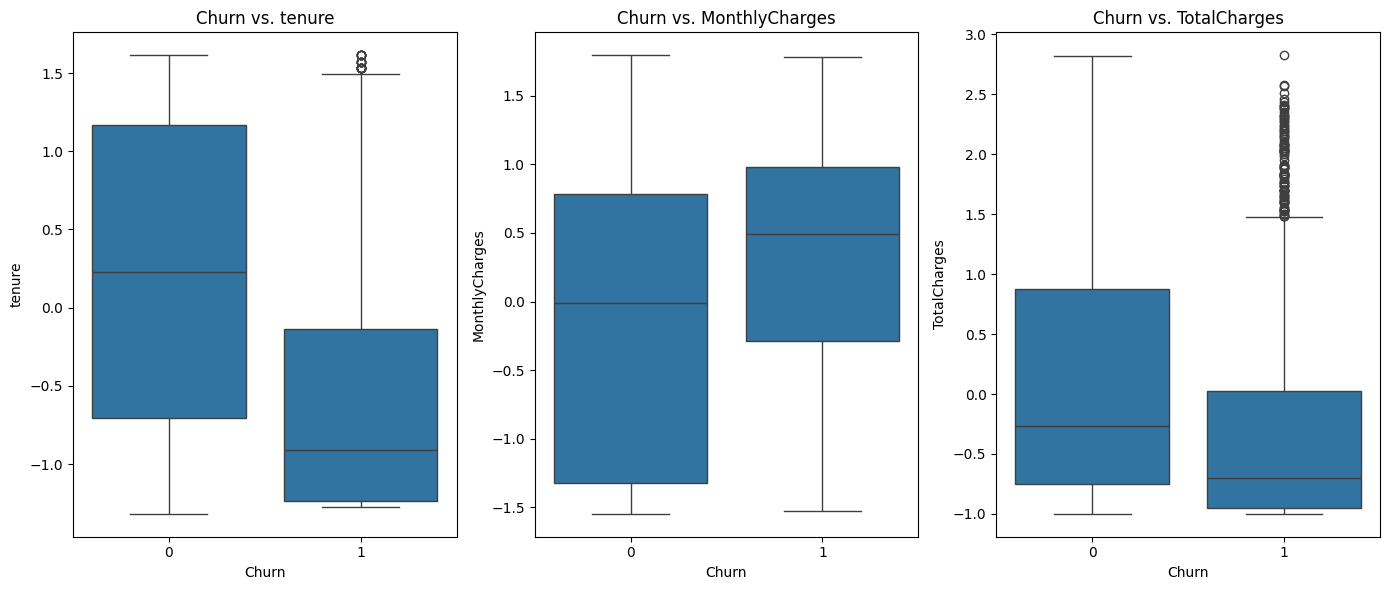

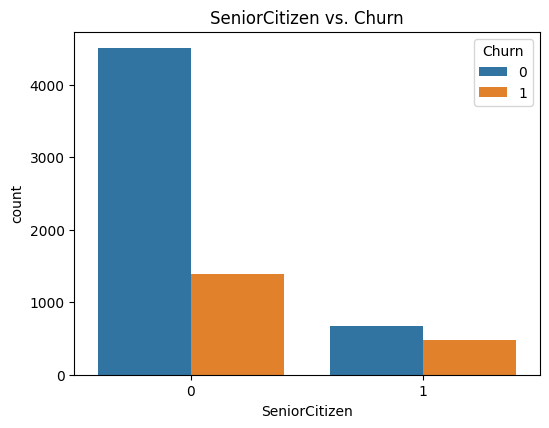

Training set size: 5634 samples
Testing set size: 1409 samples

Training Logistic Regression...

Logistic Regression training completed in 0.08 seconds

Training Decision Tree...

Decision Tree training completed in 0.07 seconds

Training Random Forest...

Random Forest training completed in 1.20 seconds

Training Gradient Boosting...

Gradient Boosting training completed in 1.69 seconds

Training XGBoost...


C:\Users\PRANAY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost training completed in 0.41 seconds

Training SVM...

SVM training completed in 10.57 seconds

Logistic Regression Evaluation:
[[934 102]
 [149 224]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409


Decision Tree Evaluation:
[[825 211]
 [201 172]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1036
           1       0.45      0.46      0.46       373

    accuracy                           0.71      1409
   macro avg       0.63      0.63      0.63      1409
weighted avg       0.71      0.71      0.71      1409


Random Forest Evaluation:
[[945  91]
 [201 172]]
              precision    recall  f1-score   support

           0       0.82      0.91

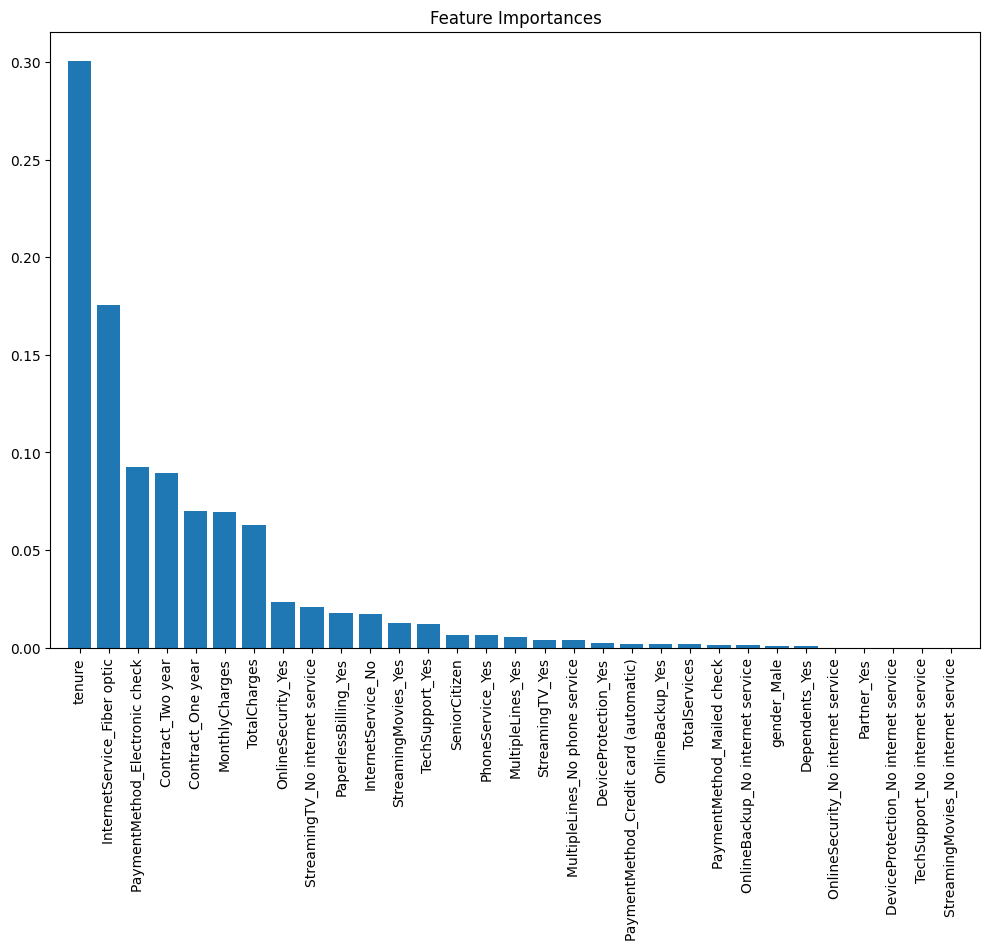

      customerID  Churn_Probability  Churn_Prediction
2208  7216-EWTRS           0.935539                 1
1807  6910-HADCM           0.908107                 1
1600  3068-OMWZA           0.885759                 1
585   5192-EBGOV           0.885571                 1
4453  1455-UGQVH           0.881940                 1
Consider strategies that address tenure to reduce churn.
Consider strategies that address InternetService_Fiber optic to reduce churn.
Consider strategies that address PaymentMethod_Electronic check to reduce churn.
Consider strategies that address Contract_Two year to reduce churn.
Consider strategies that address Contract_One year to reduce churn.
      customerID  Churn_Probability                             Action
2208  7216-EWTRS           0.935539  Offer a discount on the next bill
1807  6910-HADCM           0.908107  Offer a discount on the next bill
1600  3068-OMWZA           0.885759  Offer a discount on the next bill
585   5192-EBGOV           0.885571  Off

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import time
import pickle

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows of the dataset and basic information
print(df.head())
print(df.info())

# Check for missing values and handle them
print(df.isnull().sum())
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(df.isnull().sum())

# Convert 'Churn' column to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode categorical variables
columns_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                     'PaperlessBilling', 'PaymentMethod']
columns_in_df = df.columns.intersection(columns_to_encode)
df = pd.get_dummies(df, columns=columns_in_df, drop_first=True)
print(df.head())

# Scale numerical columns
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])
print(df.head())

# Add a new feature 'TotalServices'
df['TotalServices'] = df[['PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic', 
                          'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                          'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']].sum(axis=1)
print(df.head())

# Plot histograms and distributions
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=20, figsize=(14, 6), layout=(1, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Correlation matrix heatmap
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplots to compare churned vs. non-churned customers
plt.figure(figsize=(14, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'Churn vs. {feature}')
plt.tight_layout()
plt.show()

# Churn rate across categorical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                        'Contract', 'PaperlessBilling', 'PaymentMethod']
existing_features = [feature for feature in categorical_features if feature in df.columns]
plt.figure(figsize=(20, 20))
for i, feature in enumerate(existing_features, 1):
    plt.subplot(5, 4, i)
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'{feature} vs. Churn')
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

# Initialize and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\n{name} training completed in {training_time:.2f} seconds")

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# GridSearchCV for Logistic Regression
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                 'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga']}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

# GridSearchCV for Gradient Boosting
param_grid_gb = {'n_estimators': [50, 100, 200], 
                 'learning_rate': [0.01, 0.1, 0.2], 
                 'max_depth': [3, 4, 5]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best score for Gradient Boosting:", grid_search_gb.best_score_)

# GridSearchCV for SVM
param_grid_svm = {'C': [0.1, 1, 10], 
                  'kernel': ['linear', 'rbf'], 
                  'gamma': ['scale', 'auto']}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)

# Feature importance plot for Gradient Boosting
best_gb_model = grid_search_gb.best_estimator_
importances = best_gb_model.feature_importances_
indices = importances.argsort()[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Predict churn probabilities and identify customers likely to churn
y_pred_prob = best_gb_model.predict_proba(X_test)[:, 1]
X_test['Churn_Probability'] = y_pred_prob
X_test['Churn_Prediction'] = (y_pred_prob >= 0.5).astype(int)
X_test['customerID'] = df.loc[X_test.index, 'customerID']
results = X_test[['customerID', 'Churn_Probability', 'Churn_Prediction']]
likely_to_churn = results[results['Churn_Prediction'] == 1].sort_values(by='Churn_Probability', ascending=False)
print(likely_to_churn.head())

# Strategies based on top features
top_features = X_train.columns[indices[:5]]
for feature in top_features:
    print(f"Consider strategies that address {feature} to reduce churn.")

# Add actionable insights
likely_to_churn['Action'] = 'Offer a discount on the next bill'
print(likely_to_churn[['customerID', 'Churn_Probability', 'Action']].head(10))

# Save the best model to a file
with open('best_gb_model.pkl', 'wb') as f:
    pickle.dump(best_gb_model, f)
